In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

import zipfile

import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics 
plt.style.use('ggplot')

In [2]:
import custom_funcs as cf

In [3]:
%load_ext autoreload
%autoreload 2

In [137]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Input data

Context

This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

The datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (If I am mistaken and the public license type disallowed me from doing so, I will take this down if requested.)

Content

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

Tips

What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'. This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value. Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

KNIME is a great tool (GUI) that can be used for this.
1 - File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.
2- File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad"
3- Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)
4- Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')
5- Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and
6- Partitioning Node test data split output to input Decision Tree predictor Node
7- Decision Tree learner Node output to input Decision Tree Node input
8- Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)
Inspiration

Use machine learning to determine which physiochemical properties make a wine 'good'!

Acknowledgements

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (I am mistaken and the public license type disallowed me from doing so, I will take this down at first request. I am not the owner of this dataset.

Please include this citation if you plan to use this database:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Relevant publication

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [13]:
!ls data

archive.zip           winequality-red.csv
bank-additional.zip   winequality-white.csv


In [4]:
df_red = pd.read_csv('./data/winequality-red.csv', sep=';')
display(df_red.head(3))
df_white = pd.read_csv('./data/winequality-white.csv', sep=';')
display(df_white.head(3))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [6]:
df_red.shape, df_white.shape

((1599, 12), (4898, 12))

In [7]:
df_red['color'] = 'r'
df_white['color'] = 'w'

In [8]:
df = pd.concat([df_red, df_white])

In [9]:
df.shape

(6497, 13)

In [9]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,r
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,r


# Exploratorial Analysis

In [10]:
for col in df.columns:
    print(f'Column: {col}. Has na columns: %s' % df[col].isna().any())

Column: fixed acidity. Has na columns: False
Column: volatile acidity. Has na columns: False
Column: citric acid. Has na columns: False
Column: residual sugar. Has na columns: False
Column: chlorides. Has na columns: False
Column: free sulfur dioxide. Has na columns: False
Column: total sulfur dioxide. Has na columns: False
Column: density. Has na columns: False
Column: pH. Has na columns: False
Column: sulphates. Has na columns: False
Column: alcohol. Has na columns: False
Column: quality. Has na columns: False
Column: color. Has na columns: False


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


In [12]:
display(df['quality'].value_counts().sort_index()) 
display(df['quality'].value_counts(normalize=True).sort_index())

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

3    0.004618
4    0.033246
5    0.329075
6    0.436509
7    0.166077
8    0.029706
9    0.000770
Name: quality, dtype: float64

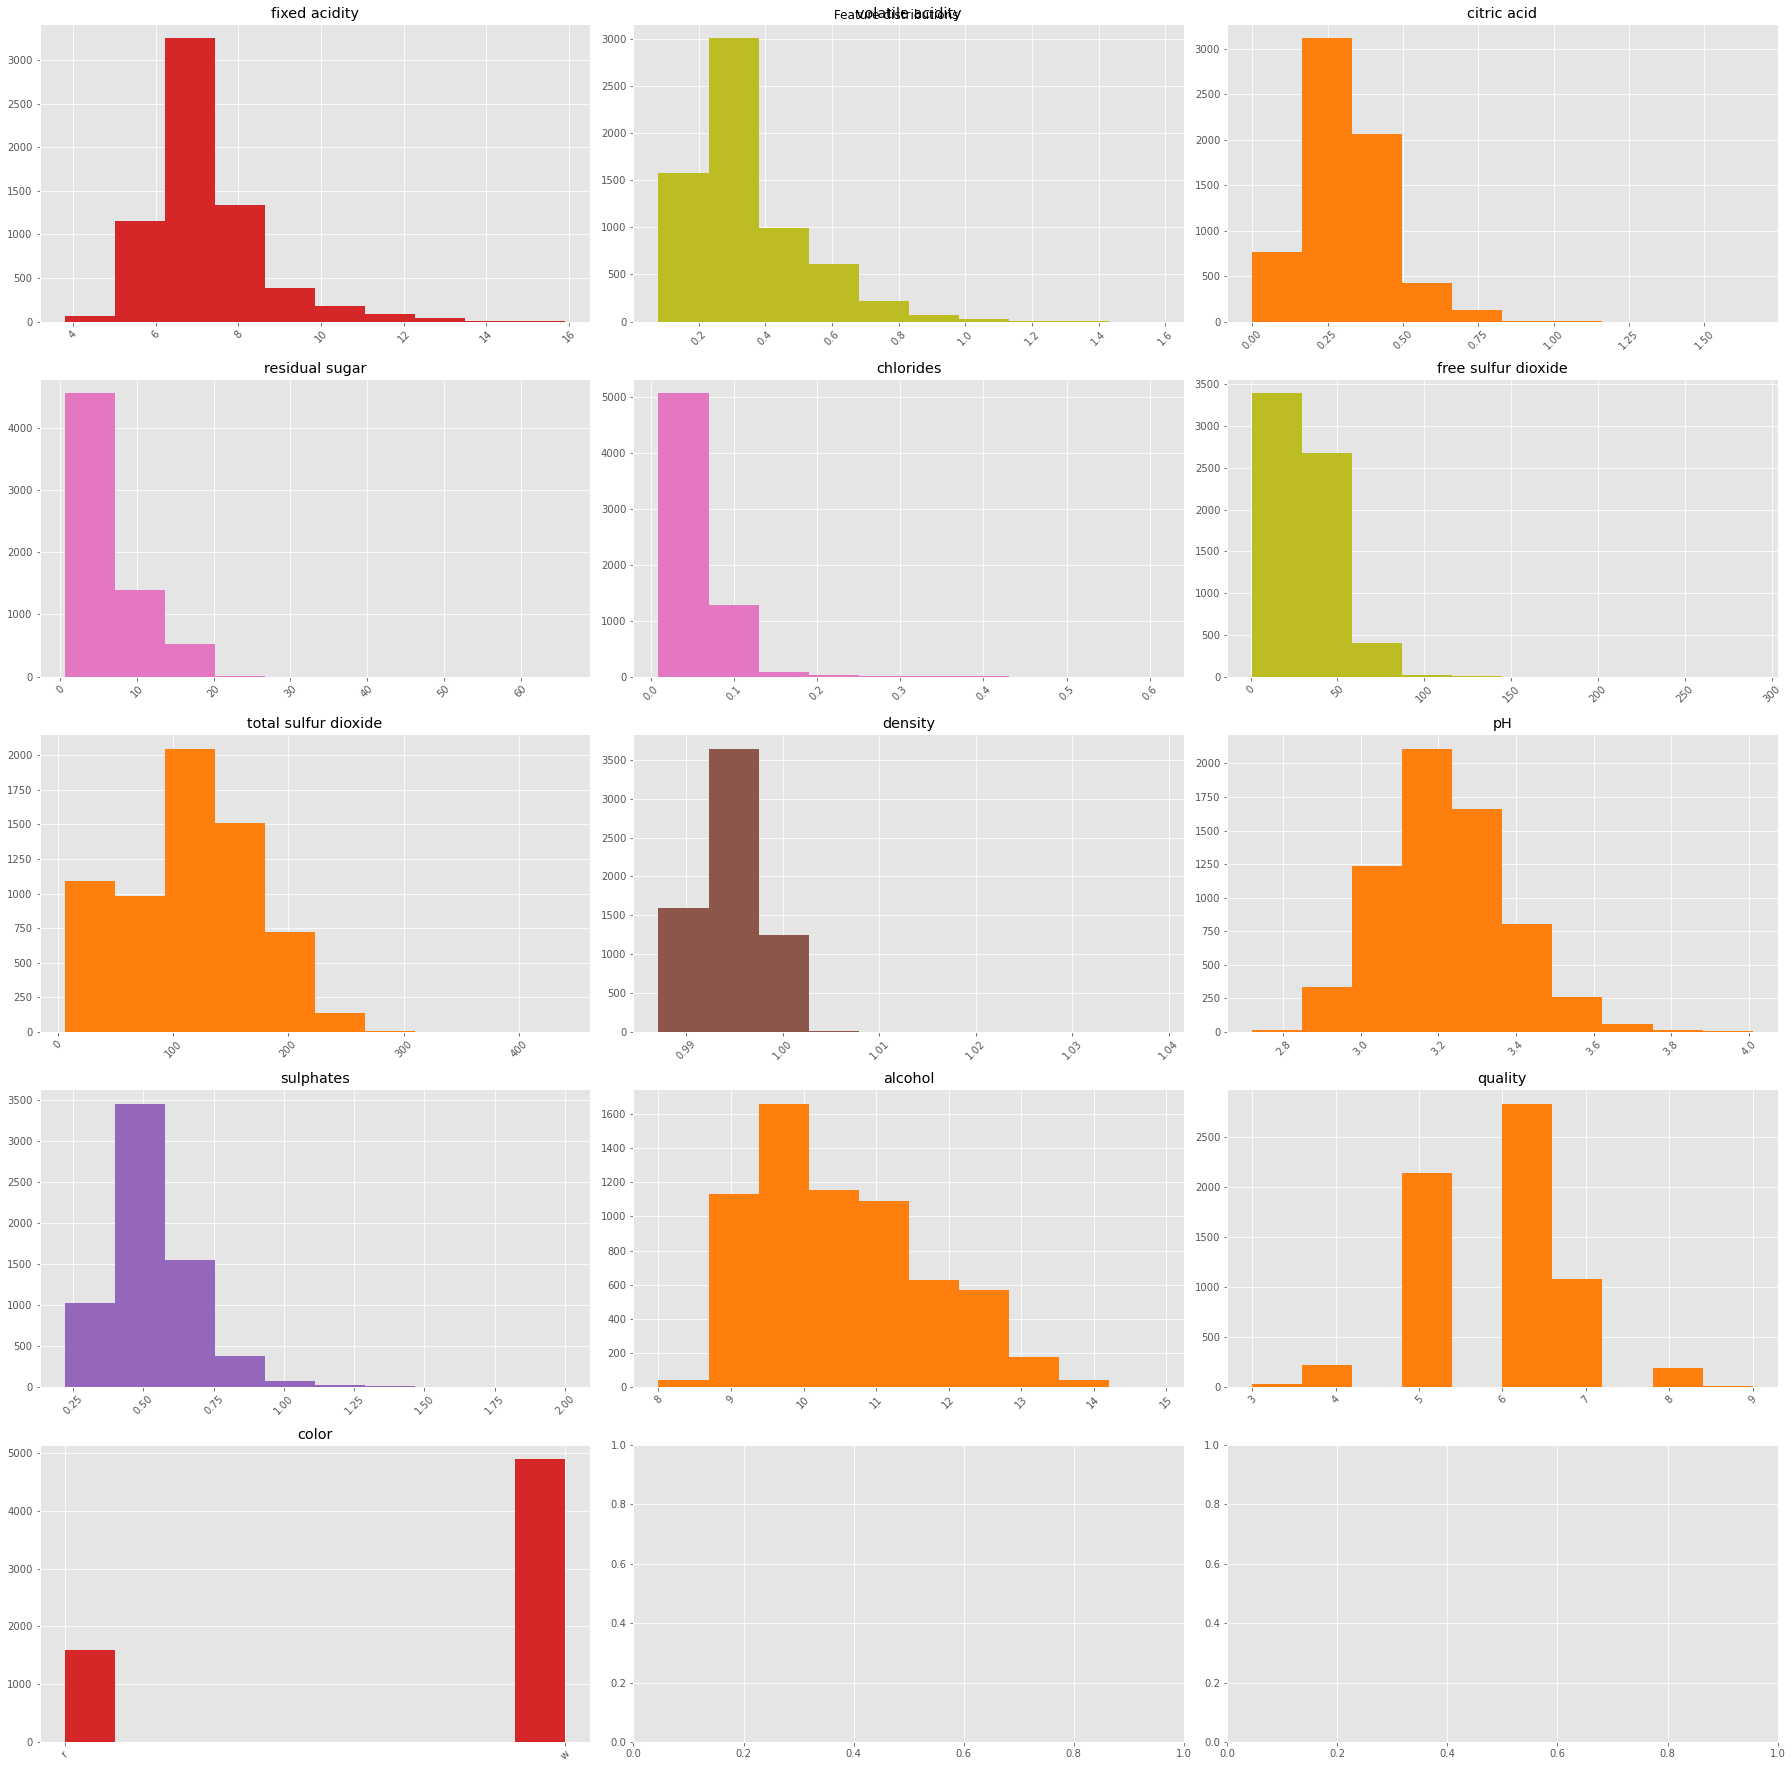

In [39]:
col_len = len(df.columns)
row_num = int(np.ceil(col_len/3))
colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan')

fig, axes = plt.subplots(row_num, 3)


fig.set_size_inches(25, row_num*5)

for num, col in enumerate(df.columns):
    cur_ax = axes[num//3][num%3]
    df[col].hist(ax=cur_ax, xrot=45, color=np.random.choice(colors))
    cur_ax.set_title(col)
    
plt.suptitle('Feature distributions')
plt.tight_layout()

In [12]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,r
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,r


## Conclusions

- The disribution of the feature values is close to normal or lognormal
- The distribution of the target label is also close to normal.

# Train, valid and test

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_X, test_X = train_test_split(df, train_size=0.9, random_state=13)

We will use 3 fold cross validation due to the fact that the dataset is not so big.

In [15]:
train_X.shape, test_X.shape

((5847, 13), (650, 13))

# Encoding

In [16]:
from sklearn.preprocessing import OneHotEncoder

As we have to explore a classification problem I should transform my label  
that has continious nature and ordered categories to pure categories.

It would be more interesting to divide wine into 3 categories according to the quality. 
It could be interpreted as:  
    - less than average  
    - average quality   
    - better than average  

In [17]:
df['quality_class'] = df['quality'].apply(lambda x: -1 if x < 5 else 1 if x > 6 else 0)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
 13  quality_class         6497 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 761.4+ KB


In [19]:
X, y, trained_ohes = cf.encode_input_data(
    df.rename(columns={'quality_class': 'y'}).drop(columns=['quality'])
)

In [20]:
trained_ohes

{'color': OneHotEncoder(handle_unknown='ignore')}

In [21]:
X.shape, y.shape

((6497, 13), (6497,))

In [22]:
pd.value_counts(y)

 0    4974
 1    1277
-1     246
dtype: int64

In [23]:
df.rename(columns={'quality_class': 'y'}).drop(columns=['quality'])['y'].value_counts()

 0    4974
 1    1277
-1     246
Name: y, dtype: int64

# Train, valid and test

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

In [25]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.9, random_state=13)

In [26]:
train_X.shape, train_y.shape

((5847, 13), (5847,))

In [27]:
test_y.shape, test_y.shape

((650,), (650,))

# Decision tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

## Max depth

In [29]:
pd.value_counts(train_y, normalize=True)

 0    0.764495
 1    0.197024
-1    0.038481
dtype: float64

In [331]:
md_metrics = \
    cf.brute_force_parameters(par_name='max_depth',
                              par_values=range(2, 50, 2),
                              estimator_kwargs={'random_state': 13},
                              x_train=train_X, y_train=train_y)

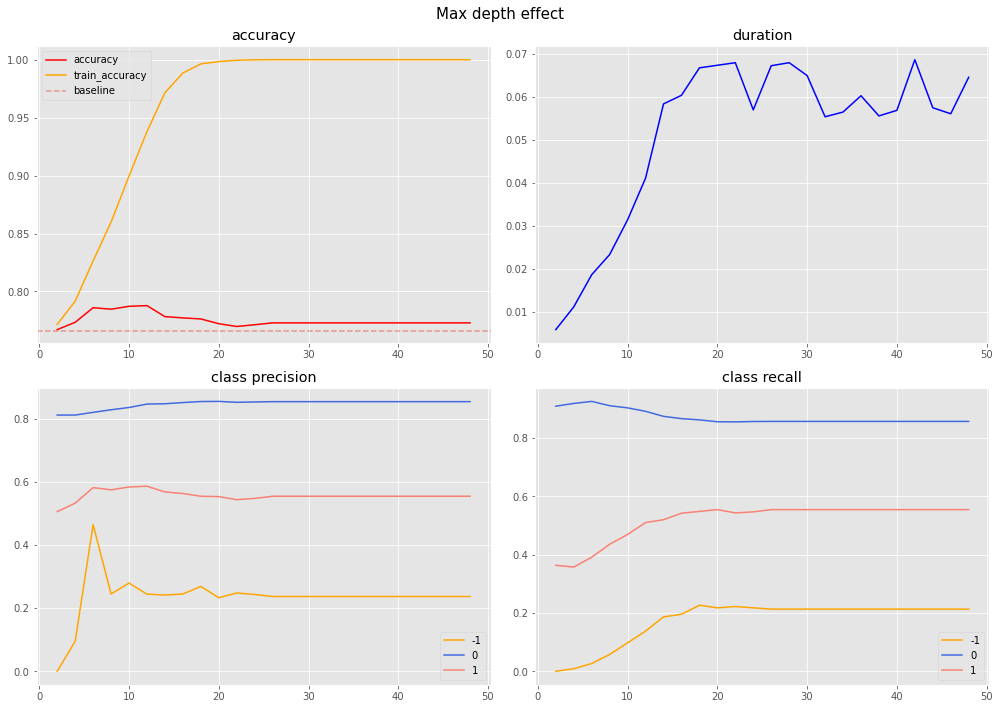

In [332]:
fig, axes = cf.plot_metrics(md_metrics, sorted(pd.unique(train_y).tolist()), baselines={'accuracy': 0.766})

In [328]:
sorted(md_metrics.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[(12,
  {'fit_time': 0.0454,
   'score_time': 0.0079,
   'test_precision_-1': 0.2443,
   'train_precision_-1': 0.9136,
   'test_precision_0': 0.846,
   'train_precision_0': 0.9391,
   'test_precision_1': 0.586,
   'train_precision_1': 0.9381,
   'test_recall_-1': 0.1378,
   'train_recall_-1': 0.6178,
   'test_recall_0': 0.8919,
   'train_recall_0': 0.9842,
   'test_recall_1': 0.5104,
   'train_recall_1': 0.8212,
   'test_accuracy': 0.7878,
   'train_accuracy': 0.938}),
 (10,
  {'fit_time': 0.033,
   'score_time': 0.0073,
   'test_precision_-1': 0.2793,
   'train_precision_-1': 0.9036,
   'test_precision_0': 0.8352,
   'train_precision_0': 0.9049,
   'test_precision_1': 0.5835,
   'train_precision_1': 0.8724,
   'test_recall_-1': 0.0978,
   'train_recall_-1': 0.3956,
   'test_recall_0': 0.9038,
   'train_recall_0': 0.973,
   'test_recall_1': 0.4696,
   'train_recall_1': 0.7127,
   'test_accuracy': 0.7872,
   'train_accuracy': 0.8995}),
 (6,
  {'fit_time': 0.018,
   'score_time': 0.0079,

In [33]:
new_baselines = cf.extract_baselines(md_metrics[12])

In [34]:
new_baselines

{'accuracy': 0.7878,
 'precision_-1': 0.2443,
 'precision_0': 0.846,
 'precision_1': 0.586,
 'recall_-1': 0.1378,
 'recall_0': 0.8919,
 'recall_1': 0.5104}

The best score is with max depth 12.
We have accuracy 0.7878

### Entropy

In [329]:
md_metrics_entropy = \
    cf.brute_force_parameters(par_name='max_depth',
                              par_values=range(2, 50, 2),
                              estimator_kwargs={'random_state': 13, 'criterion': 'entropy'},
                              x_train=train_X, y_train=train_y)

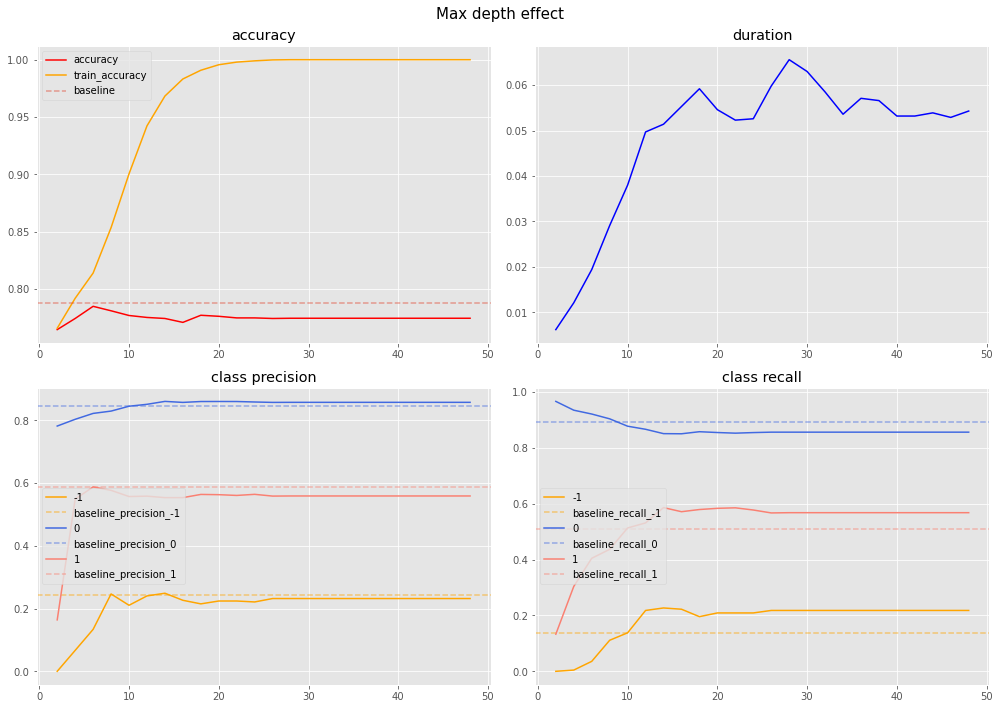

In [330]:
fig, axes = cf.plot_metrics(md_metrics_entropy, sorted(pd.unique(train_y).tolist()), baselines=new_baselines)

In [333]:
sorted(md_metrics_entropy.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:2]

[(6,
  {'fit_time': 0.0194,
   'score_time': 0.0071,
   'test_precision_-1': 0.1337,
   'train_precision_-1': 0.752,
   'test_precision_0': 0.8222,
   'train_precision_0': 0.8362,
   'test_precision_1': 0.5879,
   'train_precision_1': 0.6725,
   'test_recall_-1': 0.0356,
   'train_recall_-1': 0.1289,
   'test_recall_0': 0.9208,
   'train_recall_0': 0.9426,
   'test_recall_1': 0.4045,
   'train_recall_1': 0.4488,
   'test_accuracy': 0.785,
   'train_accuracy': 0.814}),
 (8,
  {'fit_time': 0.0291,
   'score_time': 0.0068,
   'test_precision_-1': 0.2466,
   'train_precision_-1': 0.8445,
   'test_precision_0': 0.8296,
   'train_precision_0': 0.8738,
   'test_precision_1': 0.5769,
   'train_precision_1': 0.748,
   'test_recall_-1': 0.1111,
   'train_recall_-1': 0.4222,
   'test_recall_0': 0.9036,
   'train_recall_0': 0.9461,
   'test_recall_1': 0.4366,
   'train_recall_1': 0.579,
   'test_accuracy': 0.7811,
   'train_accuracy': 0.8536})]

## Train Curve

### Train, valid  split

In [45]:
flex_train_X, valid_X, flex_train_y, valid_y = train_test_split(train_X, train_y, train_size=0.9)

In [46]:
flex_train_X.shape, valid_X.shape, flex_train_y.shape, valid_y.shape

((5262, 13), (585, 13), (5262,), (585,))

### Plot

In [336]:
np.random.seed(13)
metrics_dict = {}

dt_clf = DecisionTreeClassifier(max_depth=12, random_state=13, criterion='gini')

for i in range(10, 110, 10):
    random_index = np.random.choice(flex_train_X.shape[0], 
                                    replace=False,
                                    size=min(flex_train_X.shape[0], round(flex_train_X.shape[0] * i/100)))
    
    _, duration = cf.time_it(dt_clf.fit, flex_train_X[random_index], flex_train_y[random_index])
    
    train_preds = dt_clf.predict(flex_train_X[random_index])
    preds = dt_clf.predict(valid_X)
    
    metrics = {}
    
    metrics['test_accuracy'] = sklearn.metrics.accuracy_score(valid_y, preds)
    metrics['train_accuracy'] = sklearn.metrics.accuracy_score(
        flex_train_y[random_index], train_preds
    )
    
#     cl_precision = []
    
    for cl in sorted(np.unique(valid_y)):
        
        metrics[f'test_precision_{cl}'] = \
            sklearn.metrics.precision_score(
                np.where(valid_y == cl, 1, 0), np.where(preds == cl, 1, 0)
            )
#     cl_recall = []
    
    for cl in sorted(np.unique(valid_y)):
        
        metrics[f'test_recall_{cl}'] = \
            sklearn.metrics.recall_score(
                np.where(valid_y == cl, 1, 0), np.where(preds == cl, 1, 0)
            )
        
    metrics['fit_time'] = duration
    
    metrics_dict[i] = metrics
    print(f"{i}% Ammount: {random_index.shape[0]} {duration:.4f} seconds, accuracy: {metrics['test_accuracy']:.4f}")

10% Ammount: 526 0.0049 seconds, accuracy: 0.6701
20% Ammount: 1052 0.0107 seconds, accuracy: 0.7316
30% Ammount: 1579 0.0158 seconds, accuracy: 0.7265
40% Ammount: 2105 0.0261 seconds, accuracy: 0.7556
50% Ammount: 2631 0.0306 seconds, accuracy: 0.7761
60% Ammount: 3157 0.0385 seconds, accuracy: 0.8068
70% Ammount: 3683 0.0394 seconds, accuracy: 0.8068
80% Ammount: 4210 0.0508 seconds, accuracy: 0.7863
90% Ammount: 4736 0.0562 seconds, accuracy: 0.8239
100% Ammount: 5262 0.0605 seconds, accuracy: 0.7897


In [337]:
metrics_dict

{10: {'test_accuracy': 0.67008547008547,
  'train_accuracy': 0.9961977186311787,
  'test_precision_-1': 0.06666666666666667,
  'test_precision_0': 0.8175182481751825,
  'test_precision_1': 0.375,
  'test_recall_-1': 0.08695652173913043,
  'test_recall_0': 0.7601809954751131,
  'test_recall_1': 0.45,
  'fit_time': 0.004895925521850586},
 20: {'test_accuracy': 0.7316239316239316,
  'train_accuracy': 0.9762357414448669,
  'test_precision_-1': 0.25,
  'test_precision_0': 0.8489208633093526,
  'test_precision_1': 0.4785714285714286,
  'test_recall_-1': 0.30434782608695654,
  'test_recall_0': 0.8009049773755657,
  'test_recall_1': 0.5583333333333333,
  'fit_time': 0.010703086853027344},
 30: {'test_accuracy': 0.7264957264957265,
  'train_accuracy': 0.9772007599746675,
  'test_precision_-1': 0.0967741935483871,
  'test_precision_0': 0.8380281690140845,
  'test_precision_1': 0.5078125,
  'test_recall_-1': 0.13043478260869565,
  'test_recall_0': 0.8076923076923077,
  'test_recall_1': 0.54166666

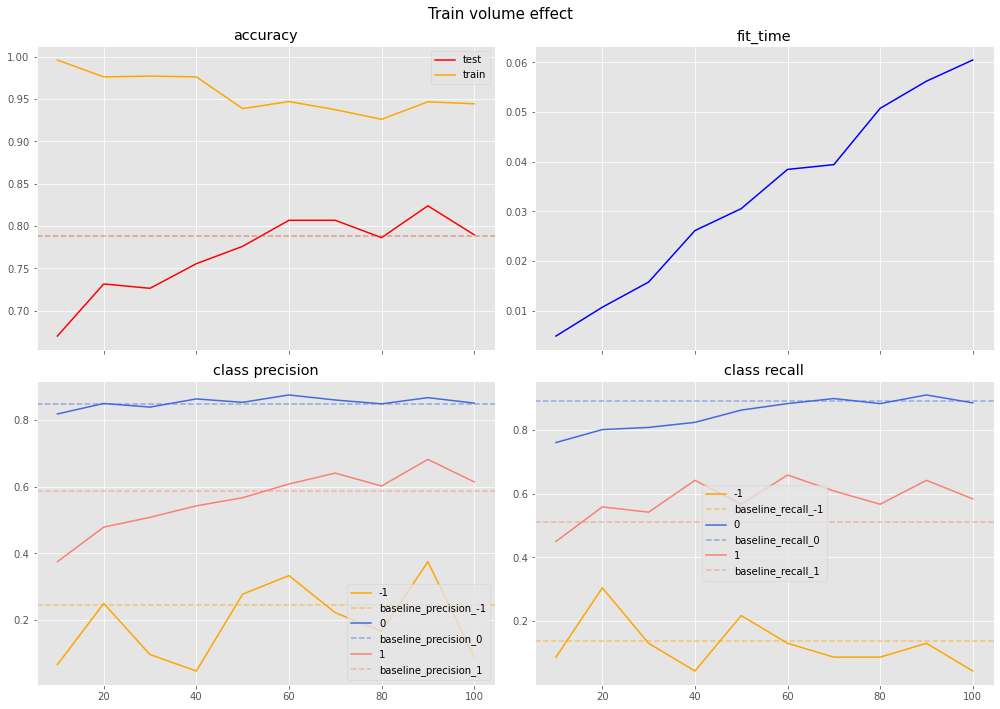

In [343]:
perc = sorted(metrics_dict.keys())
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(14, 10)

axes[0][0].plot(perc,
             [metrics_dict[x]['test_accuracy'] for x in perc], color='red', 
               label='test')
axes[0][0].plot(perc,
             [metrics_dict[x]['train_accuracy'] for x in perc], color='orange',
               label='train')
axes[0][0].legend()
axes[0][0].set_title('accuracy')
axes[0][0].axhline(new_baselines['accuracy'], linestyle='--', alpha=0.5)

axes[0][1].plot(perc,
            [metrics_dict[x]['fit_time'] for x in perc], color='blue')
axes[0][1].set_title('fit_time')


colors = ['orange', 'royalblue', 'salmon']
class_names = ['-1', '0', '1']
for i in range(3):
    axes[1][0].plot(perc,
                [metrics_dict[x][f'test_precision_{class_names[i]}'] for x in perc],
                 color=colors[i], label=class_names[i])
    axes[1][0].axhline(new_baselines[f'precision_{class_names[i]}'], color=colors[i],
                                   alpha=0.5, label=f'baseline_precision_{class_names[i]}',
                                   linestyle='--')
    
axes[1][0].legend()    
axes[1][0].set_title('class precision')

for i in range(3):
    axes[1][1].plot(perc,
                [metrics_dict[x][f'test_recall_{class_names[i]}'] for x in perc],
                 color=colors[i], label=class_names[i])
    axes[1][1].axhline(new_baselines[f'recall_{class_names[i]}'], color=colors[i],
                                   alpha=0.5, label=f'baseline_recall_{class_names[i]}',
                                   linestyle='--')
    
axes[1][1].legend()    
axes[1][1].set_title('class recall')
fig.suptitle('Train volume effect', fontsize=15)
plt.tight_layout();

In [344]:
# Conclusion - the more data we have the better score we have on the valid set

## Changing balance

In [345]:
balance_metrics = \
    cf.brute_force_parameters(par_name='max_depth',
                              par_values=range(2, 50, 2),
                              estimator_kwargs={'random_state': 13, 'criterion': 'gini',
                                                'class_weight': 'balanced', 'max_depth': 12},
                              x_train=train_X, y_train=train_y)

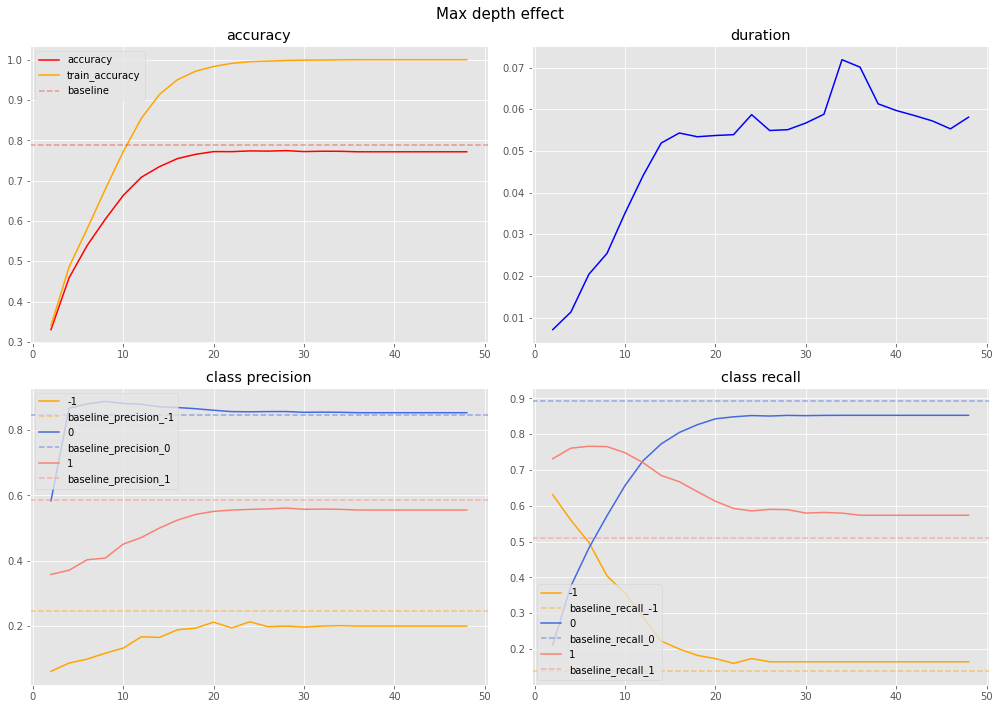

In [346]:
fig, axes = cf.plot_metrics(balance_metrics, sorted(pd.unique(train_y).tolist()), baselines=new_baselines)

In [ ]:
# Changing weights doesn't improve the model

## Pruning

In [347]:
dt_clf = DecisionTreeClassifier(max_depth=12, random_state=13, criterion='gini')

ccp_alphas, impurities = [
    dt_clf.cost_complexity_pruning_path(train_X, train_y)[x] for x in ['ccp_alphas', 'impurities']]

In [348]:
pruning_metrics = \
    cf.brute_force_parameters(par_name='ccp_alpha',
                              par_values=ccp_alphas,
                              estimator_kwargs={'random_state': 13,
                                                'criterion': 'gini',
                                                'max_depth': 12},
                              x_train=train_X, y_train=train_y)

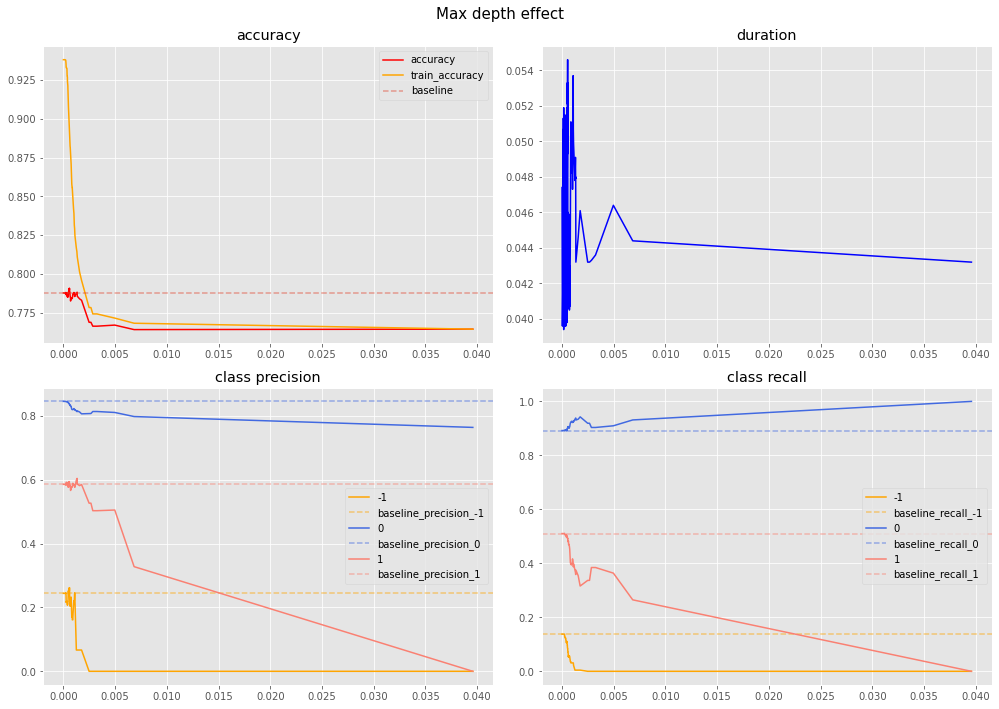

In [349]:
fig, axes = cf.plot_metrics(pruning_metrics, sorted(pd.unique(train_y).tolist()), baselines=new_baselines)

In [350]:
sorted(pruning_metrics.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[(0.0005678056222252373,
  {'fit_time': 0.045,
   'score_time': 0.0068,
   'test_precision_-1': 0.2518,
   'train_precision_-1': 0.7794,
   'test_precision_0': 0.8377,
   'train_precision_0': 0.9034,
   'test_precision_1': 0.5945,
   'train_precision_1': 0.861,
   'test_recall_-1': 0.0711,
   'train_recall_-1': 0.3111,
   'test_recall_0': 0.9056,
   'train_recall_0': 0.9681,
   'test_recall_1': 0.4861,
   'train_recall_1': 0.7201,
   'test_accuracy': 0.7908,
   'train_accuracy': 0.894}),
 (0.0005863812944367076,
  {'fit_time': 0.0437,
   'score_time': 0.0067,
   'test_precision_-1': 0.2622,
   'train_precision_-1': 0.7876,
   'test_precision_0': 0.837,
   'train_precision_0': 0.9018,
   'test_precision_1': 0.5923,
   'train_precision_1': 0.8563,
   'test_recall_-1': 0.0711,
   'train_recall_-1': 0.3022,
   'test_recall_0': 0.9063,
   'train_recall_0': 0.9677,
   'test_recall_1': 0.4826,
   'train_recall_1': 0.7144,
   'test_accuracy': 0.7907,
   'train_accuracy': 0.8922}),
 (0.00057697

In [ ]:
# Here we can prune several nodes according to cost complexity pruning parameter value

In [65]:
best_ccp_alpha = sorted(pruning_metrics.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[0][0]

In [84]:
dt_clf = DecisionTreeClassifier(
    max_depth=12, criterion='gini', random_state=13, ccp_alpha=best_ccp_alpha
)

In [69]:
scorers = cf.build_scorers(sorted(np.unique(train_y)))

In [ ]:
# Let's test our final classifier on the test_set

## Final test set score

In [86]:
dt_clf.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0005678056222252373, max_depth=12,
                       random_state=13)

In [88]:
preds = dt_clf.predict(test_X)

In [89]:
from sklearn.metrics import classification_report

In [91]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        21
           0       0.83      0.93      0.88       504
           1       0.61      0.41      0.49       125

    accuracy                           0.80       650
   macro avg       0.48      0.45      0.46       650
weighted avg       0.76      0.80      0.77       650



In [95]:
display(pd.value_counts(test_y)),  display(pd.value_counts(test_y, normalize=True))

 0    504
 1    125
-1     21
dtype: int64

 0    0.775385
 1    0.192308
-1    0.032308
dtype: float64

(None, None)

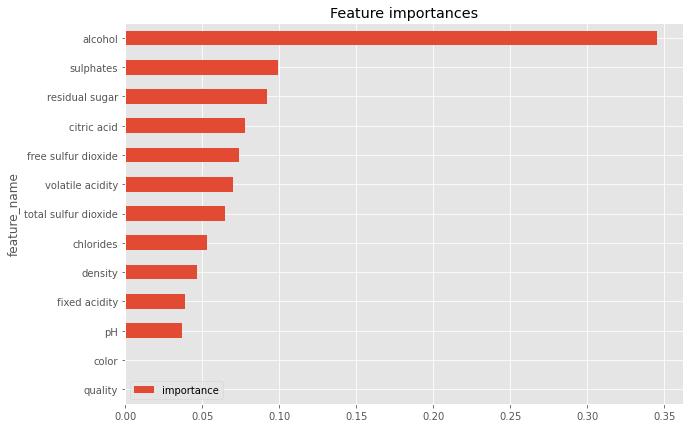

In [119]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 7))

pd.DataFrame(zip([x for x in df.columns if x != 'quality_class'],
                  dt_clf.feature_importances_.round(3)), 
            columns=['feature_name', 'importance'])\
    .set_index('feature_name')\
    .sort_values('importance')\
    .plot(kind='barh', ax=ax, title='Feature importances');

# NN

In [120]:
from sklearn.neural_network import MLPClassifier

## Depth and width

In [147]:
depth_range = range(1, 6)
width_range = range(1, 11)

scorers = cf.build_scorers(sorted(np.unique(train_y)))

depth_width_metrics = {}

total_iterations = len(depth_range) * len(width_range) * 3
i = 0 

for depth in depth_range:
    for n_neurons in width_range:
        for activation in ['relu', 'tanh', 'logistic']:
            i += 1
            print(f'\r{i}/{total_iterations}', end='')
            
            nn_clf = MLPClassifier(random_state=13,
                                   hidden_layer_sizes=[n_neurons for x in range(depth)], 
                                   activation=activation)

            nn_metrics = cross_validate(nn_clf, train_X, train_y, 
                                        scoring=scorers, cv=3)
            nn_metrics = list(map(lambda x: (x[0], x[1].mean().round(4)),
                                  nn_metrics.items()))
            
            depth_width_metrics.setdefault(activation, {})
            depth_width_metrics[activation][(depth, n_neurons)] = nn_metrics

150/150

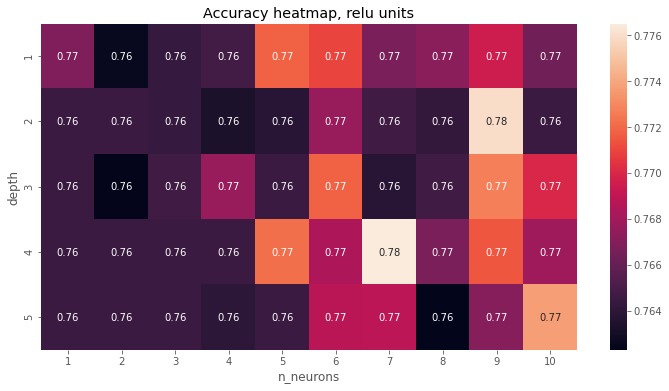

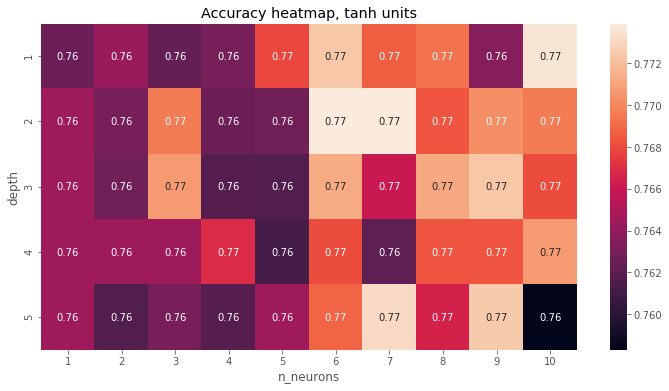

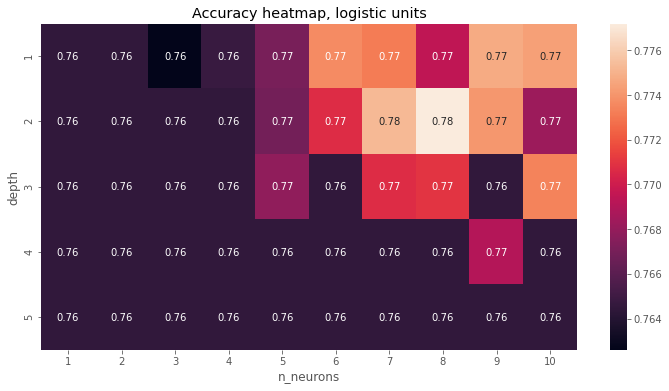

In [169]:
for activation in ['relu', 'tanh', 'logistic']:
    fig, ax = cf.plot_heatmap(depth_width_metrics[activation])
    ax.set_title(f'Accuracy heatmap, {activation} units')

In [186]:
l = []
for activation in ['relu', 'tanh', 'logistic']:
    results_df = pd.DataFrame(
        list(
            map(
            lambda x: (x[0][0], x[0][1], x[1][-1][-1], x[1][0][-1]),
            depth_width_metrics[activation].items()
            )
        ), columns=['depth', 'n_neurons', 'acc', 'train_dur']
    )
    results_df['act'] = activation
    l.append(results_df)
    
metrics_df = pd.concat(l)
metrics_df.sort_values('acc', ascending=False, inplace=True)

In [ ]:
# scaling

In [211]:
from sklearn.preprocessing import StandardScaler

In [212]:
scaler = StandardScaler()

In [214]:
train_X_scaled = scaler.fit_transform(train_X.toarray())

In [215]:
depth_range = range(1, 6)
width_range = range(1, 11)

scorers = cf.build_scorers(sorted(np.unique(train_y)))

depth_width_metrics_scaled = {}

total_iterations = len(depth_range) * len(width_range) * 3
i = 0 

for depth in depth_range:
    for n_neurons in width_range:
        for activation in ['relu', 'tanh', 'logistic']:
            i += 1
            print(f'\r{i}/{total_iterations}', end='')
            
            nn_clf = MLPClassifier(random_state=13,
                                   hidden_layer_sizes=[n_neurons for x in range(depth)], 
                                   activation=activation)

            nn_metrics = cross_validate(nn_clf, train_X_scaled, train_y, 
                                        scoring=scorers, cv=3)
            nn_metrics = list(map(lambda x: (x[0], x[1].mean().round(4)),
                                  nn_metrics.items()))
            
            depth_width_metrics_scaled.setdefault(activation, {})
            depth_width_metrics_scaled[activation][(depth, n_neurons)] = nn_metrics

150/150

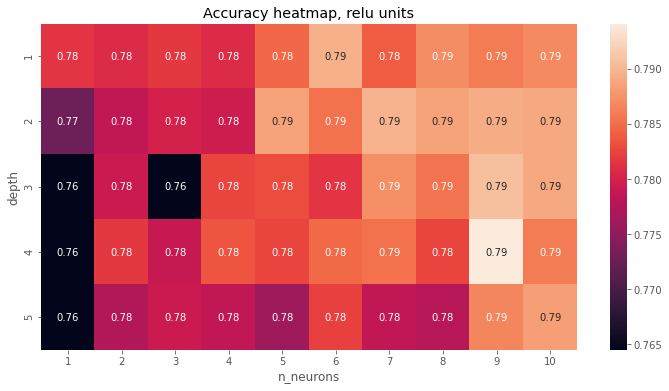

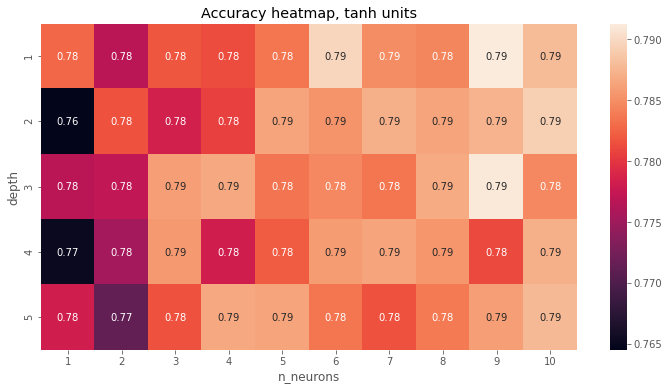

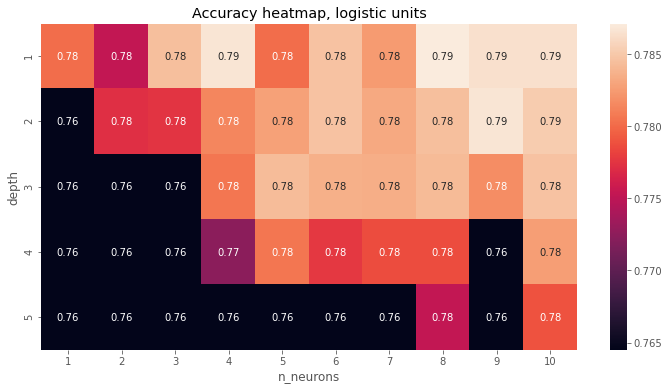

In [216]:
for activation in ['relu', 'tanh', 'logistic']:
    fig, ax = cf.plot_heatmap(depth_width_metrics_scaled[activation])
    ax.set_title(f'Accuracy heatmap, {activation} units')

In [218]:
l = []
for activation in ['relu', 'tanh', 'logistic']:
    results_df = pd.DataFrame(
        list(
            map(
            lambda x: (x[0][0], x[0][1], x[1][-1][-1], x[1][0][-1]),
            depth_width_metrics_scaled[activation].items()
            )
        ), columns=['depth', 'n_neurons', 'acc', 'train_dur']
    )
    results_df['act'] = activation
    l.append(results_df)
    
metrics_df = pd.concat(l)
metrics_df.sort_values('acc', ascending=False, inplace=True)

In [219]:
metrics_df.head(5)

,depth,n_neurons,acc,train_dur,act
38,4,9,0.7941,2.4229,relu
8,1,9,0.7913,1.5374,tanh
28,3,9,0.7910,1.8927,tanh
28,3,9,0.7907,2.0850,relu
5,1,6,0.7898,1.1715,tanh


## Alpha tuning

In [363]:
combispace = np.hstack([np.logspace(-6, 0, 50), np.linspace(1e-10, 1, 50)])

alpha_metrics_combispace = \
    cf.brute_force_parameters(par_name='alpha',
                              par_values=combispace,
                              estimator_kwargs={
                                  'random_state': 13,
                                  'activation': 'relu',
                                  'hidden_layer_sizes': [9 for x in range(4)]
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=MLPClassifier)

99/100

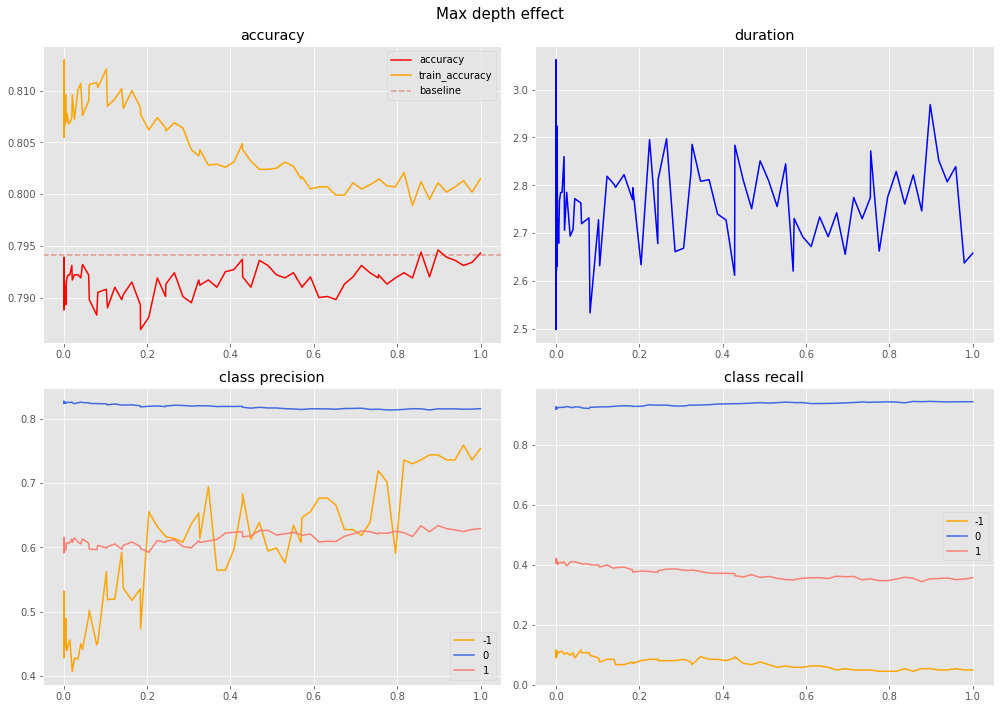

In [364]:
fig, axes = cf.plot_metrics(
    alpha_metrics_combispace, sorted(pd.unique(train_y).tolist()), baselines={"accuracy": 0.7941}
)

In [366]:
sorted(alpha_metrics_combispace.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[(0.8979591836836734,
  {'fit_time': 2.9687,
   'score_time': 0.0138,
   'test_precision_-1': 0.744,
   'train_precision_-1': 0.6707,
   'test_precision_0': 0.8156,
   'train_precision_0': 0.821,
   'test_precision_1': 0.634,
   'train_precision_1': 0.6527,
   'test_recall_-1': 0.0533,
   'train_recall_-1': 0.0711,
   'test_recall_0': 0.9456,
   'train_recall_0': 0.9468,
   'test_recall_1': 0.3533,
   'train_recall_1': 0.3785,
   'test_accuracy': 0.7946,
   'train_accuracy': 0.8011}),
 (0.8571428571571429,
  {'fit_time': 2.8219,
   'score_time': 0.0121,
   'test_precision_-1': 0.7361,
   'train_precision_-1': 0.6477,
   'test_precision_0': 0.8156,
   'train_precision_0': 0.8203,
   'test_precision_1': 0.6338,
   'train_precision_1': 0.6561,
   'test_recall_-1': 0.0444,
   'train_recall_-1': 0.0644,
   'test_recall_0': 0.9454,
   'train_recall_0': 0.948,
   'test_recall_1': 0.355,
   'train_recall_1': 0.3754,
   'test_accuracy': 0.7944,
   'train_accuracy': 0.8012}),
 (1.0,
  {'fit_time

In [370]:
best_alpha = sorted(alpha_metrics_combispace.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[0][0]

## Solver

In [367]:
solvers = ['lbfgs', 'sgd', 'adam']

In [368]:
solver_metrics = \
    cf.brute_force_parameters(par_name='solver',
                              par_values=solvers,
                              estimator_kwargs={
                                  'random_state': 13,
                                  'activation': 'relu',
                                  'hidden_layer_sizes': [9 for x in range(4)], 
                                  'alpha': best_alpha,
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=MLPClassifier)

3/3

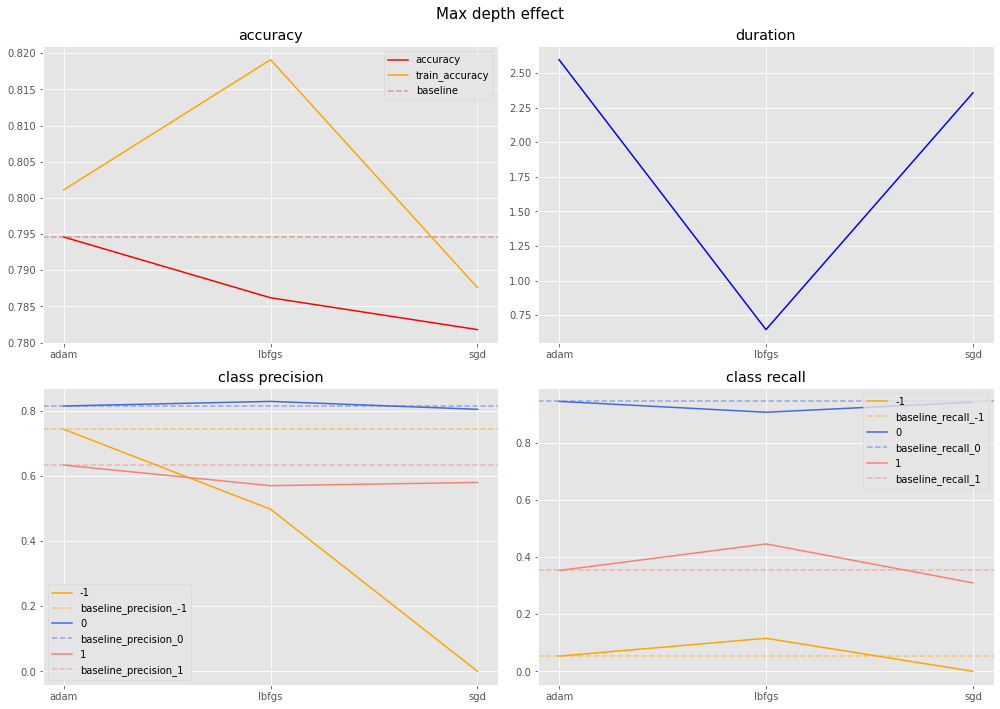

In [371]:
fig, axes = cf.plot_metrics(
    solver_metrics, sorted(pd.unique(train_y).tolist()), baselines=new_baselines_nn
)

## Learning rate

In [372]:
lr_metrics_combispace = \
    cf.brute_force_parameters(par_name=['learning_rate_init', 'max_iter'],
                              par_values=[
                                  np.logspace(-5, -1, 10), np.arange(100, 1100, 100) 
                              ],
                              estimator_kwargs={
                                  'random_state': 13,
                                  'activation': 'relu',
                                  'hidden_layer_sizes': [9 for x in range(4)], 
                                  'solver': 'adam'
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=MLPClassifier)

100/100

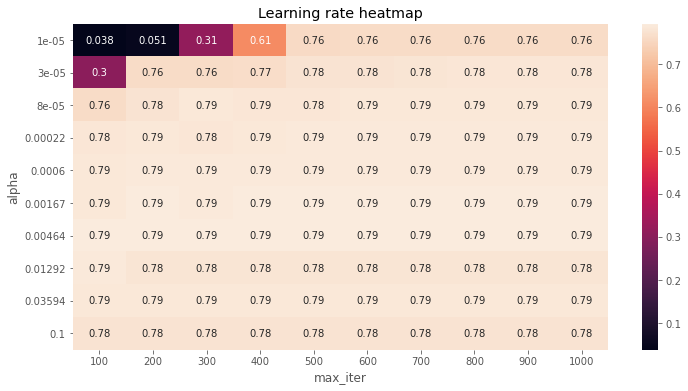

In [373]:
fig, ax = cf.plot_heatmap(lr_metrics_combispace, inner_dicts=True, colnames=['alpha', 'max_iter', 'acc'])
ax.set_title(f'Learning rate heatmap');

In [374]:
sorted(lr_metrics_combispace.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[((0.004641588833612777, 100),
  {'fit_time': 1.2524,
   'score_time': 0.0122,
   'test_precision_-1': 0.541,
   'train_precision_-1': 0.7202,
   'test_precision_0': 0.8354,
   'train_precision_0': 0.844,
   'test_precision_1': 0.5988,
   'train_precision_1': 0.63,
   'test_recall_-1': 0.1067,
   'train_recall_-1': 0.2,
   'test_recall_0': 0.9114,
   'train_recall_0': 0.9215,
   'test_recall_1': 0.4731,
   'train_recall_1': 0.4896,
   'test_accuracy': 0.7941,
   'train_accuracy': 0.8086}),
 ((0.004641588833612777, 200),
  {'fit_time': 1.6451,
   'score_time': 0.0126,
   'test_precision_-1': 0.4569,
   'train_precision_-1': 0.6925,
   'test_precision_0': 0.8341,
   'train_precision_0': 0.8458,
   'test_precision_1': 0.6036,
   'train_precision_1': 0.6431,
   'test_recall_-1': 0.1022,
   'train_recall_-1': 0.2044,
   'test_recall_0': 0.9132,
   'train_recall_0': 0.9255,
   'test_recall_1': 0.4661,
   'train_recall_1': 0.4944,
   'test_accuracy': 0.7939,
   'train_accuracy': 0.8128}),
 ((

## Adaptive

In [320]:
lr_metrics_combispace_sgd = \
    cf.brute_force_parameters(par_name=['learning_rate_init', 'tol'],
                                  par_values=[
                                      np.logspace(-5, -1, 10), np.logspace(-5, -1, 10) 
                                  ],
                                  estimator_kwargs={
                                      'random_state': 13,
                                      'activation': 'relu',
                                      'hidden_layer_sizes': [9 for x in range(4)], 
                                      'solver': 'sgd', 
                                      'learning_rate': 'adaptive'
                                  },
                                  x_train=train_X_scaled, y_train=train_y, 
                                  estimator=MLPClassifier)

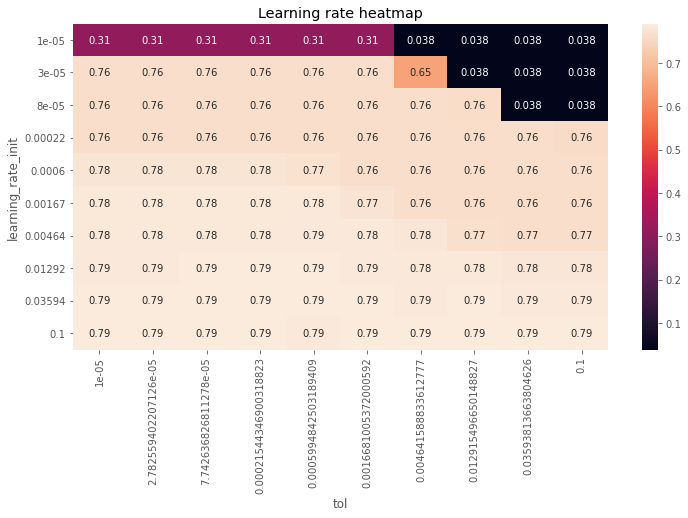

In [321]:
fig, ax = cf.plot_heatmap(lr_metrics_combispace_sgd, inner_dicts=True, colnames=['learning_rate_init', 'tol', 'acc'])
ax.set_title(f'Learning rate heatmap');

In [375]:
sorted(lr_metrics_combispace_sgd.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[((0.1, 0.0016681005372000592),
  {'fit_time': 1.8619,
   'score_time': 0.0118,
   'test_precision_-1': 0.4278,
   'test_precision_0': 0.8333,
   'test_precision_1': 0.5907,
   'test_recall_-1': 0.1067,
   'test_recall_0': 0.9096,
   'test_recall_1': 0.4627,
   'test_accuracy': 0.7907}),
 ((0.1, 0.03593813663804626),
  {'fit_time': 1.1471,
   'score_time': 0.0117,
   'test_precision_-1': 0.4103,
   'test_precision_0': 0.821,
   'test_precision_1': 0.6002,
   'test_recall_-1': 0.0178,
   'test_recall_0': 0.9284,
   'test_recall_1': 0.4045,
   'test_accuracy': 0.7901}),
 ((0.1, 0.1),
  {'fit_time': 1.1478,
   'score_time': 0.0116,
   'test_precision_-1': 0.4103,
   'test_precision_0': 0.821,
   'test_precision_1': 0.6002,
   'test_recall_-1': 0.0178,
   'test_recall_0': 0.9284,
   'test_recall_1': 0.4045,
   'test_accuracy': 0.7901})]

## Early stopping

In [318]:
cf.brute_force_parameters(par_name='early_stopping',
                              par_values=[
                                  True, False
                              ],
                              estimator_kwargs={
                                  'random_state': 13,
                                  'activation': 'relu',
                                  'hidden_layer_sizes': [9 for x in range(4)], 
                                  'solver': 'sgd', 
                                  'learning_rate': 'constant'
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=MLPClassifier)

{True: {'fit_time': 0.2015,
  'score_time': 0.0115,
  'test_precision_-1': 0.1111,
  'test_precision_0': 0.7646,
  'test_precision_1': 0.0,
  'test_recall_-1': 0.0133,
  'test_recall_0': 0.9984,
  'test_recall_1': 0.0,
  'test_accuracy': 0.7638},
 False: {'fit_time': 2.4311,
  'score_time': 0.0117,
  'test_precision_-1': 0.381,
  'test_precision_0': 0.809,
  'test_precision_1': 0.5855,
  'test_recall_-1': 0.0089,
  'test_recall_0': 0.9389,
  'test_recall_1': 0.3307,
  'test_accuracy': 0.7833}}

## Test set

In [ ]:
best_kwargs = {
    {'random_state': 13,
      'activation': 'relu',
      'hidden_layer_sizes': [9 for x in range(4)], 
      'solver': 'adam', 
    }
nn_clf = MLPClassifier(**best_kwargs)
nn_clf.fit(X_) 

In [376]:
test_X_scaled = scaler.transform(test_X.toarray())

In [379]:
nn_clf.fit(train_X_scaled, train_y)
nn_test_preds = nn_clf.predict(test_X_scaled)

In [380]:
print(classification_report(test_y, nn_test_preds))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        21
           0       0.82      0.94      0.88       504
           1       0.58      0.33      0.42       125

    accuracy                           0.79       650
   macro avg       0.47      0.42      0.43       650
weighted avg       0.75      0.79      0.76       650



# KNN

In [381]:
from sklearn.neighbors import KNeighborsClassifier

In [382]:
KNeighborsClassifier()

sklearn.neighbors._classification.KNeighborsClassifier

In [ ]:
n_neighbors=5,
*,
weights='uniform',
algorithm='auto',
leaf_size=30,
p=2,
metric='minkowski',
metric_params=None,
n_jobs=None,

## Scaled

In [384]:
k_metrics_ = \
    cf.brute_force_parameters(par_name='n_neighbors',
                              par_values=range(1, 11),
                              estimator_kwargs={
                                  'n_jobs': 3
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=KNeighborsClassifier)

10/10

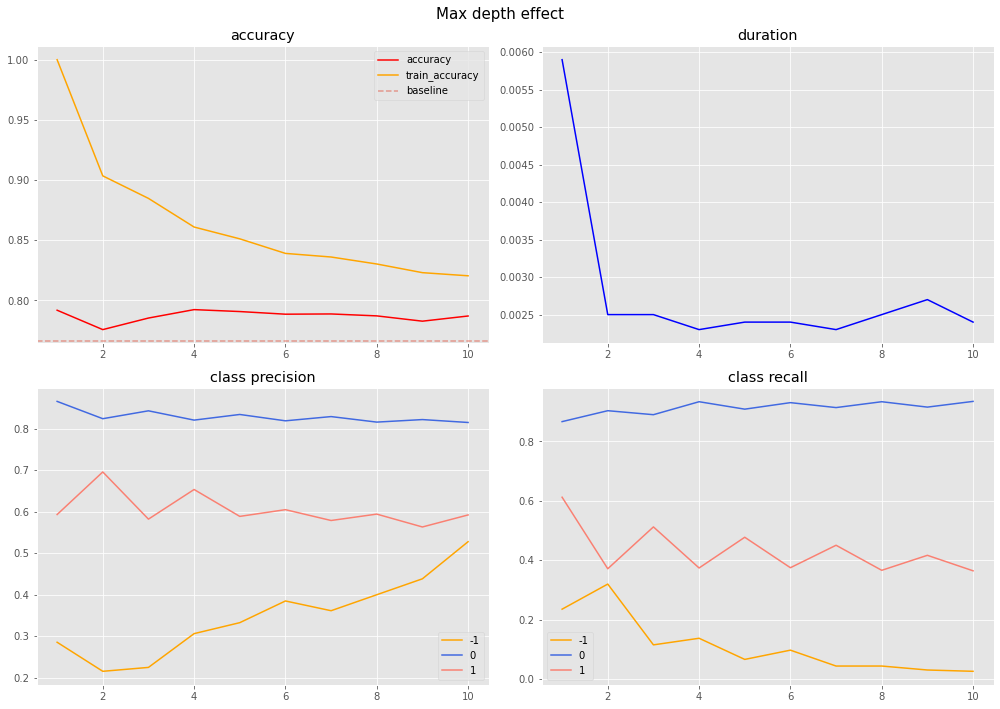

In [385]:
fig, axes = cf.plot_metrics(
    k_metrics_, sorted(pd.unique(train_y).tolist()), baselines={'accuracy': 0.766}
)

## Not scaled

In [386]:
k_metrics_unscaled = \
    cf.brute_force_parameters(par_name='n_neighbors',
                              par_values=range(1, 11),
                              estimator_kwargs={
                                  'n_jobs': 3
                              },
                              x_train=train_X, y_train=train_y, 
                              estimator=KNeighborsClassifier)

10/10

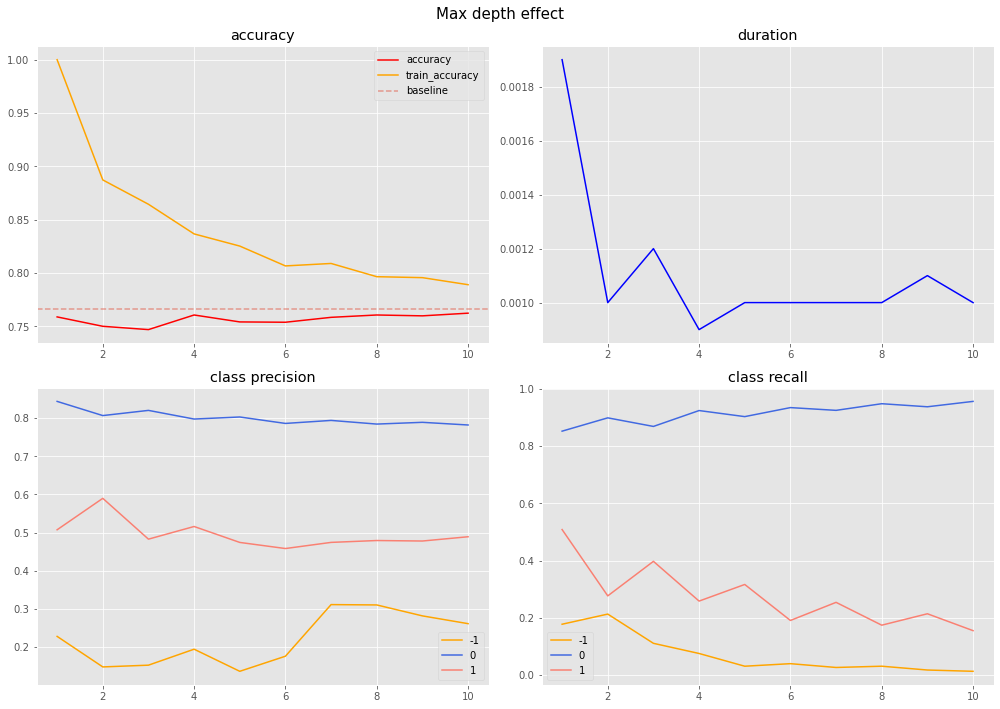

In [387]:
fig, axes = cf.plot_metrics(
    k_metrics_unscaled, sorted(pd.unique(train_y).tolist()), baselines={'accuracy': 0.766}
)

In [388]:
sorted(k_metrics_.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[(4,
  {'fit_time': 0.0023,
   'score_time': 0.5787,
   'test_precision_-1': 0.3063,
   'train_precision_-1': 0.6746,
   'test_precision_0': 0.8208,
   'train_precision_0': 0.8675,
   'test_precision_1': 0.6536,
   'train_precision_1': 0.8472,
   'test_recall_-1': 0.1378,
   'train_recall_-1': 0.3756,
   'test_recall_0': 0.9331,
   'train_recall_0': 0.9678,
   'test_recall_1': 0.3741,
   'train_recall_1': 0.5412,
   'test_accuracy': 0.7924,
   'train_accuracy': 0.861}),
 (1,
  {'fit_time': 0.0059,
   'score_time': 3.201,
   'test_precision_-1': 0.2855,
   'train_precision_-1': 1.0,
   'test_precision_0': 0.8659,
   'train_precision_0': 1.0,
   'test_precision_1': 0.5933,
   'train_precision_1': 1.0,
   'test_recall_-1': 0.2356,
   'train_recall_-1': 1.0,
   'test_recall_0': 0.8662,
   'train_recall_0': 1.0,
   'test_recall_1': 0.612,
   'train_recall_1': 1.0,
   'test_accuracy': 0.7919,
   'train_accuracy': 1.0}),
 (5,
  {'fit_time': 0.0024,
   'score_time': 0.6246,
   'test_precision_

In [389]:
new_baselines = cf.extract_baselines(k_metrics_[4])

## Distance metric

In [395]:
possible_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
distance_metrics_ = \
    cf.brute_force_parameters(par_name='metric',
                              par_values=possible_metrics,
                              estimator_kwargs={
                                  'n_neighbors': 4,
                                  'n_jobs': 3
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=KNeighborsClassifier)

4/4

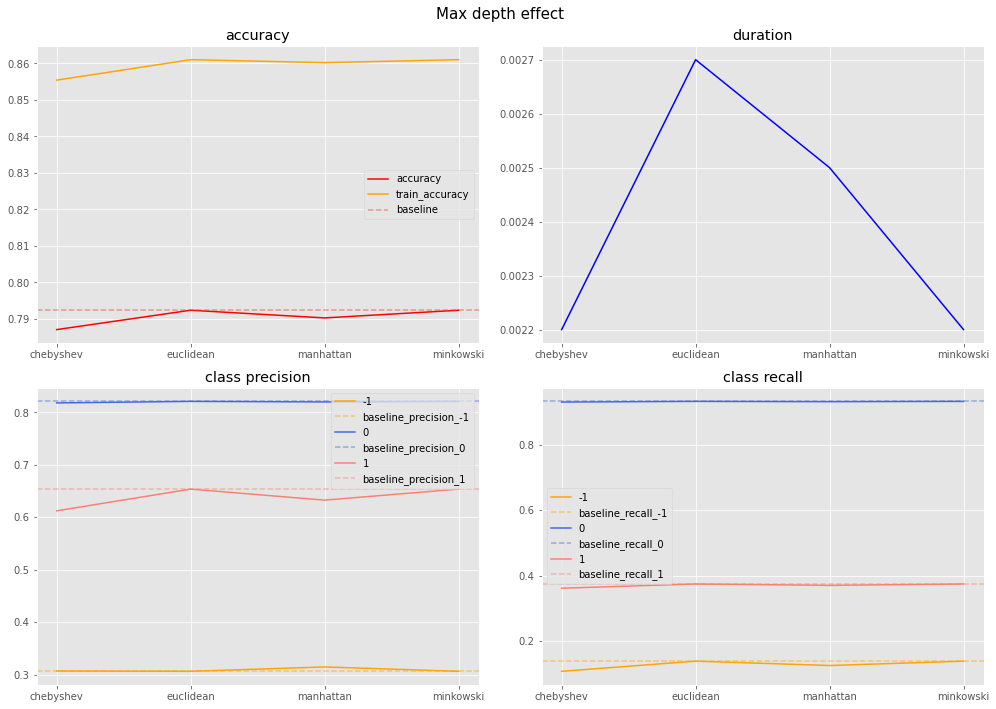

In [396]:
fig, axes = cf.plot_metrics(
    distance_metrics_, sorted(pd.unique(train_y).tolist()), baselines=new_baselines
)

In [398]:
sorted(distance_metrics_.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[('euclidean',
  {'fit_time': 0.0027,
   'score_time': 0.5626,
   'test_precision_-1': 0.3063,
   'train_precision_-1': 0.6746,
   'test_precision_0': 0.8208,
   'train_precision_0': 0.8675,
   'test_precision_1': 0.6536,
   'train_precision_1': 0.8472,
   'test_recall_-1': 0.1378,
   'train_recall_-1': 0.3756,
   'test_recall_0': 0.9331,
   'train_recall_0': 0.9678,
   'test_recall_1': 0.3741,
   'train_recall_1': 0.5412,
   'test_accuracy': 0.7924,
   'train_accuracy': 0.861}),
 ('minkowski',
  {'fit_time': 0.0022,
   'score_time': 0.5634,
   'test_precision_-1': 0.3063,
   'train_precision_-1': 0.6746,
   'test_precision_0': 0.8208,
   'train_precision_0': 0.8675,
   'test_precision_1': 0.6536,
   'train_precision_1': 0.8472,
   'test_recall_-1': 0.1378,
   'train_recall_-1': 0.3756,
   'test_recall_0': 0.9331,
   'train_recall_0': 0.9678,
   'test_recall_1': 0.3741,
   'train_recall_1': 0.5412,
   'test_accuracy': 0.7924,
   'train_accuracy': 0.861}),
 ('manhattan',
  {'fit_time': 

In [ ]:
# The results are the same

## K + metrics

In [399]:
k_distance_metrics = \
    cf.brute_force_parameters(par_name=['n_neighbors', 'metric'],
                              par_values=[
                                  range(1, 11), possible_metrics 
                              ],
                              estimator_kwargs={
                                  'n_jobs': 3
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=KNeighborsClassifier)

40/40

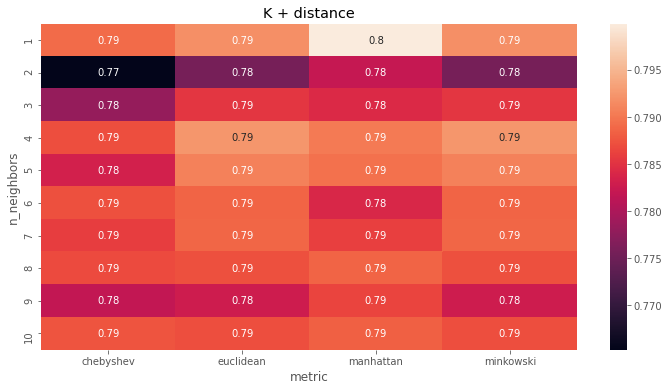

In [400]:
fig, ax = cf.plot_heatmap(k_distance_metrics, inner_dicts=True, colnames=['n_neighbors', 'metric', 'acc'])
ax.set_title(f'K + distance');

In [401]:
sorted(k_distance_metrics.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[((1, 'manhattan'),
  {'fit_time': 0.0025,
   'score_time': 0.5775,
   'test_precision_-1': 0.328,
   'train_precision_-1': 1.0,
   'test_precision_0': 0.8708,
   'train_precision_0': 1.0,
   'test_precision_1': 0.6063,
   'train_precision_1': 1.0,
   'test_recall_-1': 0.2667,
   'train_recall_-1': 1.0,
   'test_recall_0': 0.872,
   'train_recall_0': 1.0,
   'test_recall_1': 0.6241,
   'train_recall_1': 1.0,
   'test_accuracy': 0.7999,
   'train_accuracy': 1.0}),
 ((4, 'euclidean'),
  {'fit_time': 0.0023,
   'score_time': 0.5893,
   'test_precision_-1': 0.3063,
   'train_precision_-1': 0.6746,
   'test_precision_0': 0.8208,
   'train_precision_0': 0.8675,
   'test_precision_1': 0.6536,
   'train_precision_1': 0.8472,
   'test_recall_-1': 0.1378,
   'train_recall_-1': 0.3756,
   'test_recall_0': 0.9331,
   'train_recall_0': 0.9678,
   'test_recall_1': 0.3741,
   'train_recall_1': 0.5412,
   'test_accuracy': 0.7924,
   'train_accuracy': 0.861}),
 ((4, 'minkowski'),
  {'fit_time': 0.0024,

## Averaging strategy

In [402]:
k_distance_metrics_average = \
    cf.brute_force_parameters(par_name=['n_neighbors', 'metric'],
                              par_values=[
                                  range(1, 11), possible_metrics 
                              ],
                              estimator_kwargs={
                                  'n_jobs': 3,
                                  'weights': 'distance',
                              },
                              x_train=train_X_scaled, y_train=train_y, 
                              estimator=KNeighborsClassifier)

40/40

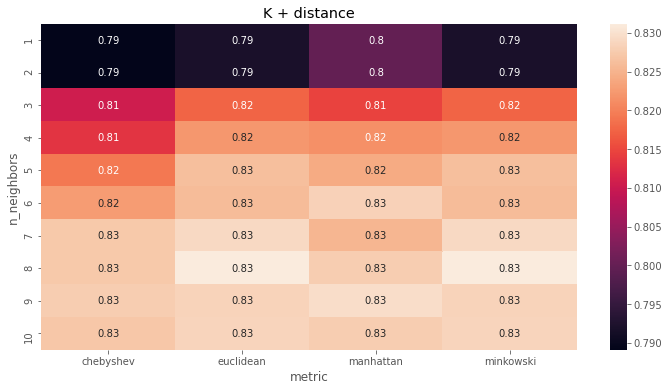

In [403]:
fig, ax = cf.plot_heatmap(k_distance_metrics_average, inner_dicts=True, colnames=['n_neighbors', 'metric', 'acc'])
ax.set_title(f'K + distance');

In [404]:
sorted(k_distance_metrics_average.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[((8, 'euclidean'),
  {'fit_time': 0.0022,
   'score_time': 0.278,
   'test_precision_-1': 0.8312,
   'train_precision_-1': 1.0,
   'test_precision_0': 0.8585,
   'train_precision_0': 1.0,
   'test_precision_1': 0.6934,
   'train_precision_1': 1.0,
   'test_recall_-1': 0.1022,
   'train_recall_-1': 1.0,
   'test_recall_0': 0.9345,
   'train_recall_0': 1.0,
   'test_recall_1': 0.5729,
   'train_recall_1': 1.0,
   'test_accuracy': 0.8312,
   'train_accuracy': 1.0}),
 ((8, 'minkowski'),
  {'fit_time': 0.0022,
   'score_time': 0.2618,
   'test_precision_-1': 0.8312,
   'train_precision_-1': 1.0,
   'test_precision_0': 0.8585,
   'train_precision_0': 1.0,
   'test_precision_1': 0.6934,
   'train_precision_1': 1.0,
   'test_recall_-1': 0.1022,
   'train_recall_-1': 1.0,
   'test_recall_0': 0.9345,
   'train_recall_0': 1.0,
   'test_recall_1': 0.5729,
   'train_recall_1': 1.0,
   'test_accuracy': 0.8312,
   'train_accuracy': 1.0}),
 ((9, 'manhattan'),
  {'fit_time': 0.0025,
   'score_time': 0

## Final test

In [407]:
knn_clf = KNeighborsClassifier(n_jobs=3, weights='distance', n_neighbors=8, metric='euclidean')

In [408]:
knn_clf.fit(train_X_scaled, train_y)

KNeighborsClassifier(metric='euclidean', n_jobs=3, n_neighbors=8,
                     weights='distance')

In [409]:
knn_preds = knn_clf.predict(test_X_scaled)

In [410]:
print(classification_report(test_y, knn_preds))

              precision    recall  f1-score   support

          -1       0.67      0.19      0.30        21
           0       0.89      0.94      0.92       504
           1       0.76      0.67      0.71       125

    accuracy                           0.87       650
   macro avg       0.77      0.60      0.64       650
weighted avg       0.86      0.87      0.86       650



# Boosting

In [411]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
AdaBoostClassifier(base_estimator=DecisionTreeClassifier)

In [ ]:
tree_depth_n_est_metrics = \
    cf.brute_force_parameters(par_name=['base_estimator', 'n_estimators'],
                              par_values=[
                                  [DecisionTreeClassifier(random_state=13, max_depth=x) 
                                  for x in range(1, 21, 2)],
                                  range(10, 150, 10), 
                              ],
                              estimator_kwargs={
                                  'random_state': 13,
                              },
                              x_train=train_X, y_train=train_y, 
                              estimator=AdaBoostClassifier)

122/140

In [426]:
copy_for_plot = {}

for d_key in tree_depth_n_est_metrics.keys():
    md = d_key[0].max_depth
    n_est = d_key[1]
    copy_for_plot[(md, n_est)] = tree_depth_n_est_metrics[d_key]

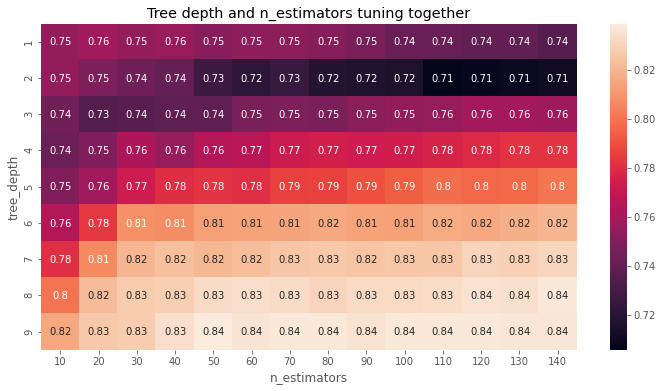

In [427]:
fig, ax = cf.plot_heatmap(copy_for_plot, inner_dicts=True, colnames=['tree_depth', 'n_estimators', 'acc'])
ax.set_title(f'Tree depth and n_estimators tuning together');

In [428]:
sorted(copy_for_plot.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)[:3]

[((9, 50),
  {'fit_time': 1.6084,
   'score_time': 0.1558,
   'test_precision_-1': 0.7838,
   'train_precision_-1': 1.0,
   'test_precision_0': 0.8501,
   'train_precision_0': 1.0,
   'test_precision_1': 0.7706,
   'train_precision_1': 1.0,
   'test_recall_-1': 0.1022,
   'train_recall_-1': 1.0,
   'test_recall_0': 0.9593,
   'train_recall_0': 1.0,
   'test_recall_1': 0.5156,
   'train_recall_1': 1.0,
   'test_accuracy': 0.8389,
   'train_accuracy': 1.0}),
 ((9, 120),
  {'fit_time': 4.1474,
   'score_time': 0.3811,
   'test_precision_-1': 0.8028,
   'train_precision_-1': 1.0,
   'test_precision_0': 0.8493,
   'train_precision_0': 1.0,
   'test_precision_1': 0.7712,
   'train_precision_1': 1.0,
   'test_recall_-1': 0.0933,
   'train_recall_-1': 1.0,
   'test_recall_0': 0.9591,
   'train_recall_0': 1.0,
   'test_recall_1': 0.5148,
   'train_recall_1': 1.0,
   'test_accuracy': 0.8382,
   'train_accuracy': 1.0}),
 ((9, 80),
  {'fit_time': 3.0217,
   'score_time': 0.2579,
   'test_precision